In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.utils import plot_model

Cargamos los datos para pruebas a partir de un archivo parquet:

In [2]:
df = pd.read_parquet('data_export/prueba_ml.parquet')
df.reset_index(inplace=True, drop=True)
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia
0,2023-11-01,0.0,8.6725,0.1,60.153034,0.0,3,12,2196,232,1,2023,11,1
1,2023-11-01,1.0,8.5725,0.0,60.344471,0.0,2,12,1521,55,0,2023,11,1
2,2023-11-01,2.0,8.3225,0.1,62.933163,0.0,3,8,1214,16,0,2023,11,1
3,2023-11-01,3.0,8.0725,0.0,66.100021,0.0,0,13,854,20,0,2023,11,1
4,2023-11-01,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1


Agregamos la variable día de la semana

In [3]:
df['dia_semana'] = df['fecha'].dt.weekday + 1
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia,dia_semana
0,2023-11-01,0.0,8.6725,0.1,60.153034,0.0,3,12,2196,232,1,2023,11,1,3
1,2023-11-01,1.0,8.5725,0.0,60.344471,0.0,2,12,1521,55,0,2023,11,1,3
2,2023-11-01,2.0,8.3225,0.1,62.933163,0.0,3,8,1214,16,0,2023,11,1,3
3,2023-11-01,3.0,8.0725,0.0,66.100021,0.0,0,13,854,20,0,2023,11,1,3
4,2023-11-01,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1,3


Agregaremos una nueva variable que representa los días festivos o holidays. Para ello utilizamos la biblioteca holidays:

In [4]:
from datetime import date
import holidays

# Obtener los días festivos en Nueva York para un año específico
year = 2023
us_holidays = holidays.US(years=year)
us_holidays
df['holiday'] = np.where(df['fecha'].isin(us_holidays), 1, 0)
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia,dia_semana,holiday
0,2023-11-01,0.0,8.6725,0.1,60.153034,0.0,3,12,2196,232,1,2023,11,1,3,0
1,2023-11-01,1.0,8.5725,0.0,60.344471,0.0,2,12,1521,55,0,2023,11,1,3,0
2,2023-11-01,2.0,8.3225,0.1,62.933163,0.0,3,8,1214,16,0,2023,11,1,3,0
3,2023-11-01,3.0,8.0725,0.0,66.100021,0.0,0,13,854,20,0,2023,11,1,3,0
4,2023-11-01,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1,3,0


Vamos a correr nuevamente hacia adelante los datos de lluvia y nieve, para utilizarlos tal como vienen en la API.

In [5]:
df['rain'] = df['rain'].shift(1)
df['snowfall'] = df['snowfall'].shift(1)

In [6]:
df.fillna(0.0, inplace=True)
df.head()

,fecha,hora,temperature_2m,rain,relative_humidity_2m,snowfall,Bronx,Brooklyn,Manhattan,Queens,Staten Island,año,mes,dia,dia_semana,holiday
0,2023-11-01,0.0,8.6725,0.0,60.153034,0.0,3,12,2196,232,1,2023,11,1,3,0
1,2023-11-01,1.0,8.5725,0.1,60.344471,0.0,2,12,1521,55,0,2023,11,1,3,0
2,2023-11-01,2.0,8.3225,0.0,62.933163,0.0,3,8,1214,16,0,2023,11,1,3,0
3,2023-11-01,3.0,8.0725,0.1,66.100021,0.0,0,13,854,20,0,2023,11,1,3,0
4,2023-11-01,4.0,7.7725,0.0,72.938622,0.0,12,20,654,25,0,2023,11,1,3,0


Definimos las columnas X e Y y luego las matrices correspondientes:

In [7]:
columnas_X = ['año', 'mes', 'dia', 'hora', 'dia_semana', 'holiday', 'temperature_2m', 'rain', 'relative_humidity_2m', 'snowfall']
X = df[columnas_X]

columnas_Y= ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
Y = df[columnas_Y]

Definimos una función que devuelve un tensor 3D con la cantidad de pasos de tiempo que se especifique para utilizar como entrada en la capa LSTM

In [8]:
def generador_X_Y(X, Y, p):
    ''' 
    A partir dos dataframes, X e Y, y los pasos de tiempo, retorna un tensor 3D para X y una array 2D para Y.
    args:
    - X: pandas dataframe, con m filas (muestras) y n columnas (features)
    - Y: pandas dataframe, con m filas (muestras) e y columnas (longitud de vector de respuesta)
    - p (int): número de pasos de tiempo a considerar
    returns:
    - X_reshaped: numpy array de forma (m, p, n)
    - Y_reshaped: numpy array de forma (m, y)
    '''
    
    X_reshaped_list = list()
    Y_rehaped_list = list()

    m = len(X)
    X = np.array(X)
    Y = np.array(Y)

    for i in range(m-p):
        X_reshaped_list.append(X[i:i+p, :])
        Y_rehaped_list.append(Y[i+p-1, :])
    
    X_reshaped = np.array(X_reshaped_list)
    Y_reshaped = np.array(Y_rehaped_list)

    return X_reshaped, Y_reshaped

Tener en cuenta que, con el procesamiento anterior, se está haciendo la predicción de la demanda de la hora actual, a partir de los datos de fecha y climáticos de la hora actual + los de las horas anteriores según los pasos de tiempo cargados.

Ahora definimos una función para evaluar diferentes parámetros de los modelos:

In [9]:
def evaluar_modelos_pasos(X, Y, nro_pasos=25, nro_capas_lstm=1, unidades_capa= [50], loss_= 'mse', act_salida='linear', act_lstm= 'relu'):
    # Normalizamos los datos
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    # Generamos listas vacías para almacenar datos
    lista_loss = []
    lista_pasos = []

    # Dividimos los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

    for pasos in range(1,nro_pasos):

        # Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
        X_train_reshaped, Y_train_reshaped = generador_X_Y(X_train, Y_train, pasos)
        X_test_reshaped, Y_test_reshaped = generador_X_Y(X_test, Y_test, pasos)

        # Construimos el modelo LSTM
        model = Sequential()
        if nro_capas_lstm > 1:

            model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
            for i in range(1, nro_capas_lstm-1):
                model.add(LSTM(units=unidades_capa[i], activation=act_lstm, return_sequences=True))
            model.add(LSTM(units=unidades_capa[-1], activation=act_lstm))
            model.add(Dense(units=Y_train_reshaped.shape[1], activation=act_salida))
        
        if nro_capas_lstm == 1:
            model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
            model.add(Dense(units=Y_train_reshaped.shape[1], activation=act_salida))

        model.compile(optimizer='adam', loss=loss_)  # Compilación del modelo 
        
        # Entrenamos el modelo
        model.fit(X_train_reshaped, Y_train_reshaped, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=0)

        # Evaluamos del modelo
        loss = model.evaluate(X_test_reshaped, Y_test_reshaped)
        print('Número de pasos',pasos ,'Loss (MSE):', loss)
        lista_pasos.append(pasos)
        lista_loss.append(loss)

    sns.lineplot(x= lista_pasos, y=lista_loss)
    plt.title('Evaluación de modelos LSTM')
    plt.xlabel('Número de pasos')
    plt.ylabel('Loss')
    plt.show()

    mejor_paso = lista_pasos[lista_loss.index(min(lista_loss))]

    return mejor_paso

Definimos ahora una función para construir un modelo determinado.

In [10]:
def construir_modelo(X, Y, nro_pasos, nro_capas_lstm=1, unidades_capa= [50], loss_= 'mse', act_salida='linear', act_lstm= 'relu', 
                     epochs= 50, batch= 32, drop_out= 0, scaler= 'minmax'):
    # Normalizar los datos
    if scaler == 'minmax':
        scaler_X = MinMaxScaler()
        scaler_Y = MinMaxScaler()
    if scaler == 'standard':
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

    # Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
    X_train_reshaped, Y_train_reshaped = generador_X_Y(X_train, Y_train, nro_pasos)
    X_test_reshaped, Y_test_reshaped = generador_X_Y(X_test, Y_test, nro_pasos)

    # Construimos el modelo LSTM
    model = Sequential()
    if nro_capas_lstm > 1:

        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
        model.add(Dropout(drop_out))
        for i in range(1, nro_capas_lstm-1):
            model.add(LSTM(units=unidades_capa[i], activation=act_lstm, return_sequences=True))
            model.add(Dropout(drop_out))
        model.add(LSTM(units=unidades_capa[-1], activation=act_lstm))
        model.add(Dense(units=Y_train_reshaped.shape[1], activation=act_salida))
    
    if nro_capas_lstm == 1:
        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
        model.add(Dropout(drop_out))
        model.add(Dense(units=Y_train_reshaped.shape[1], activation=act_salida))

    model.compile(optimizer='adam', loss=loss_)  # Compilación del modelo 
    
    model.summary()

    # Entrenamos el modelo y guardamos el historial de entrenamiento
    history = model.fit(X_train_reshaped, Y_train_reshaped, epochs=epochs, batch_size=batch, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=0)

    # Extraemos los valores de la función de pérdida del historial de entrenamiento
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    final_loss = history.history['val_loss'][-1]
    print("Valor final de Loss:", final_loss)
    
    # Graficamos la curva de aprendizaje
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Curva de Aprendizaje')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped

Por último, definimos una función para graficar las predicciones:

In [11]:
def graficar_pred_test(X_test_reshaped, Y_test_reshaped, modelo, scaler_Y):
    Y_test_df = pd.DataFrame(Y_test_reshaped, columns=columnas_Y)
    Y_test_original = scaler_Y.inverse_transform(Y_test_df)
    Y_test_original_df = pd.DataFrame(Y_test_original, columns=columnas_Y)

    Y_predict = modelo.predict(X_test_reshaped)
    Y_predict_df = pd.DataFrame(Y_predict, columns=columnas_Y)
    Y_predict_original = scaler_Y.inverse_transform(Y_predict_df)
    Y_predict_original_df = pd.DataFrame(Y_predict_original, columns=columnas_Y)

    for i in columnas_Y:
        sns.lineplot(x=Y_predict_original_df.index, y=Y_predict_original_df[i], label='Predicción')
        sns.lineplot(x=Y_test_original_df.index, y=Y_test_original_df[i], label= 'Real')
        plt.xticks(rotation=45)
        plt.legend()
        plt.show()

Hagamos una primera prueba:




10/10 [==============================] - 0s 566us/step - loss: 0.0193
Número de pasos 1 Loss (MSE): 0.019341006875038147
10/10 [==============================] - 0s 893us/step - loss: 0.0209
Número de pasos 2 Loss (MSE): 0.020894918590784073
10/10 [==============================] - 0s 5ms/step - loss: 0.0209
Número de pasos 3 Loss (MSE): 0.02086401730775833
10/10 [==============================] - 0s 5ms/step - loss: 0.0198
Número de pasos 4 Loss (MSE): 0.01976182498037815
9/9 [==============================] - 0s 6ms/step - loss: 0.0190
Número de pasos 5 Loss (MSE): 0.018955834209918976
9/9 [==============================] - 0s 6ms/step - loss: 0.0180
Número de pasos 6 Loss (MSE): 0.01796622946858406
9/9 [==============================] - 0s 9ms/step - loss: 0.0158
Número de pasos 7 Loss (MSE): 0.0157623328268528
9/9 [==============================] - 0s 6ms/step - loss: 0.0164
Número de pasos 8 Loss (MSE): 0.01640503481030464
9/9 [==============================] - 0s 6ms/step - lo

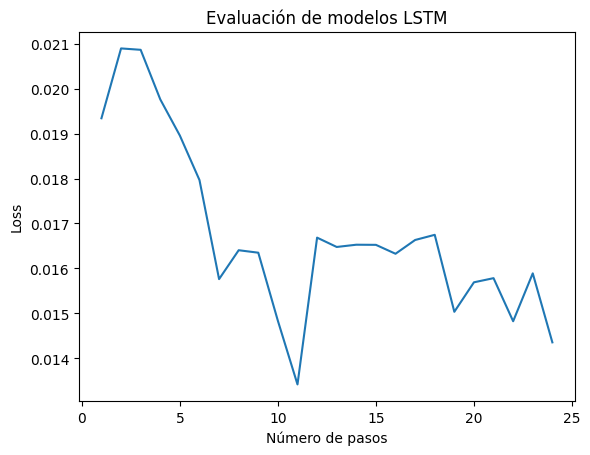

In [50]:
mejor_paso = evaluar_modelos_pasos(X, Y, act_lstm='sigmoid', act_salida='sigmoid')

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 50)                12200     
                                                                 
 dense_24 (Dense)            (None, 5)                 255       
                                                                 
Total params: 12455 (48.65 KB)
Trainable params: 12455 (48.65 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Valor final de Loss: 0.015417476184666157


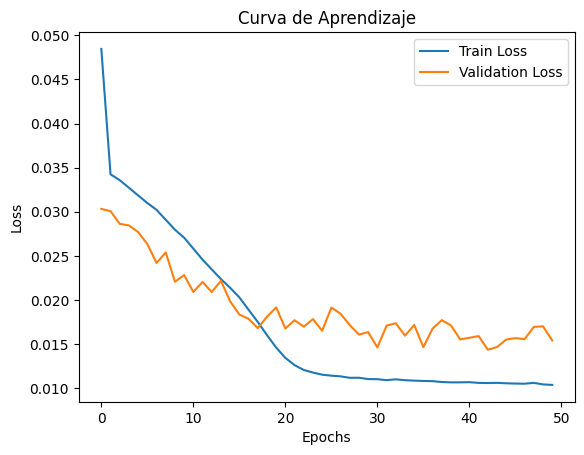

In [51]:
model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped = construir_modelo(X, Y, mejor_paso, act_lstm='sigmoid', act_salida='sigmoid')

9/9 [==============================] - 0s 2ms/step


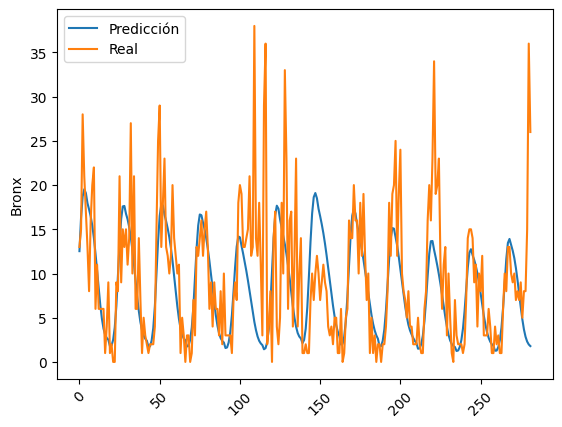

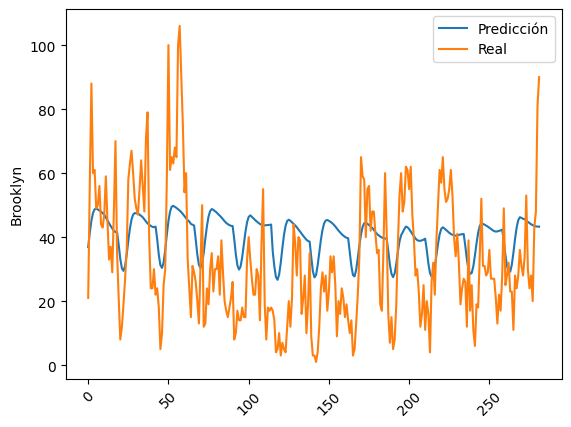

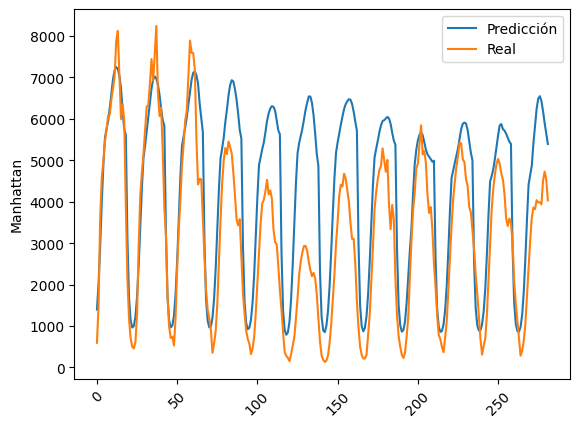

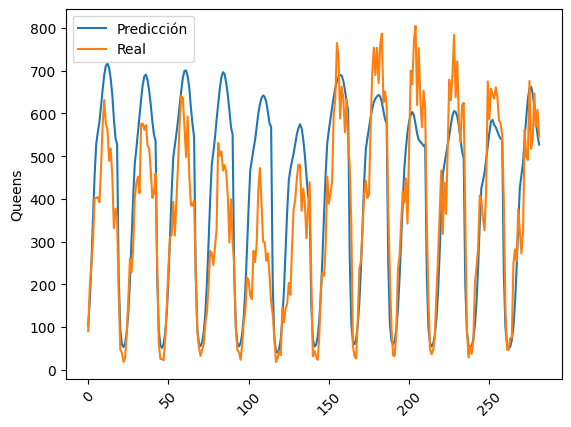

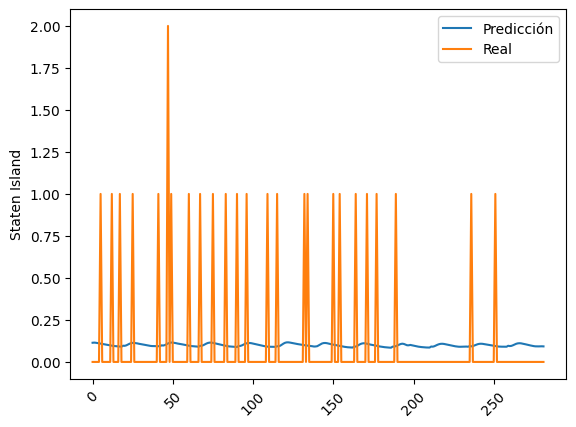

In [52]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, model, scaler_Y)

Definamos una nueva función que permita hacer una evaluación completa:

In [47]:
def evaluar_modelo_2(X, Y, nro_pasos=1, nro_capas_lstm=1, unidades_capa= [50], loss_= 'mse', act_salida='linear', act_lstm= 'relu'):
    # Normalizamos los datos
    scaler_X = MinMaxScaler()
    scaler_Y = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)
    Y_scaled = scaler_Y.fit_transform(Y)

    # Dividimos los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

    # Reshape de los datos para que sean 3D (número de muestras, número de pasos de tiempo, número de características)
    X_train_reshaped, Y_train_reshaped = generador_X_Y(X_train, Y_train, nro_pasos)
    X_test_reshaped, Y_test_reshaped = generador_X_Y(X_test, Y_test, nro_pasos)

    # Construimos el modelo LSTM
    model = Sequential()
    if nro_capas_lstm > 1:

        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
        for i in range(1, nro_capas_lstm-1):
            model.add(LSTM(units=unidades_capa[i], activation=act_lstm, return_sequences=True))
        model.add(LSTM(units=unidades_capa[-1], activation=act_lstm))
        model.add(Dense(units=Y_train_reshaped.shape[1], activation=act_salida))
    
    if nro_capas_lstm == 1:
        model.add(LSTM(units=unidades_capa[0], activation=act_lstm, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
        model.add(Dense(units=Y_train_reshaped.shape[1], activation=act_salida))

    model.compile(optimizer='adam', loss=loss_)  # Compilación del modelo 
    
    # Entrenamos el modelo
    model.fit(X_train_reshaped, Y_train_reshaped, epochs=50, batch_size=32, validation_data=(X_test_reshaped, Y_test_reshaped), verbose=0)

    # Evaluamos del modelo
    if loss_ == 'mse':
        loss = model.evaluate(X_test_reshaped, Y_test_reshaped)
    else:
        y_pred = model.predict(X_test_reshaped)
        loss = np.mean(tf.keras.losses.mean_squared_error(Y_test_reshaped, y_pred).numpy())
    
    return loss

In [48]:
def evaluar_modelos(X, Y, nro_pasos=25, nro_capas_lstm=[1], unidades_capa= [50], loss_= ['mse', 'mae'], act_salida=['linear'], act_lstm= ['relu']):

    columnas = ['nro_pasos', 'nro_capas_lstm', 'unidades_capa', 'loss_function', 'act_salida', 'act_lstm', 'loss_value(mse)']

    evaluacion = pd.DataFrame(columns=columnas)
    i = 0
    combinaciones = nro_pasos*len(nro_capas_lstm)*len(loss_)*len(act_salida)*len(act_lstm)
    mejor_loss = float('inf')
    mejor_combinacion = 0
    for pasos in range(1,nro_pasos):
        for capas in nro_capas_lstm:
            for loss_f in loss_:
                for act_s in act_salida:
                    for act_l in act_lstm:
                        loss = evaluar_modelo_2(X, Y, pasos, capas, unidades_capa, loss_f, act_s, act_l)
                        unidades_capa_str = ', '.join(map(str, unidades_capa))
                        evaluacion.loc[i] = [pasos, capas, unidades_capa_str, loss_f, act_s, act_l, loss]
                        i+=1
                        if loss < mejor_loss:
                            mejor_combinacion = i
                            mejor_loss = loss
                        print(f'Finalizada combinación {i} de {combinaciones}. Loss= {loss}')
                        print(f'Mejor combinación: {mejor_combinacion}. Loss: {mejor_loss}')
    
    return evaluacion

In [49]:
df_eval = evaluar_modelos(X, Y, nro_pasos=25, nro_capas_lstm=[1,2,3], unidades_capa=[50, 30, 20], loss_=['mse'], act_salida= ['linear', 'relu'],
                act_lstm= ['relu', 'sigmoid'])

10/10 [==============================] - 0s 2ms/step - loss: 0.0222
Finalizada combinación 1 de 300. Loss= 0.0222434401512146
Mejor combinación: 1. Loss: 0.0222434401512146
10/10 [==============================] - 0s 0s/step - loss: 0.0224
Finalizada combinación 2 de 300. Loss= 0.022429483011364937
Mejor combinación: 1. Loss: 0.0222434401512146
10/10 [==============================] - 0s 851us/step - loss: 0.0217
Finalizada combinación 3 de 300. Loss= 0.021742762997746468
Mejor combinación: 3. Loss: 0.021742762997746468
10/10 [==============================] - 0s 1ms/step - loss: 0.0213
Finalizada combinación 4 de 300. Loss= 0.021287700161337852
Mejor combinación: 4. Loss: 0.021287700161337852
10/10 [==============================] - 0s 2ms/step - loss: 0.0172
Finalizada combinación 5 de 300. Loss= 0.017203262075781822
Mejor combinación: 5. Loss: 0.017203262075781822
10/10 [==============================] - 0s 2ms/step - loss: 0.0199
Finalizada combinación 6 de 300. Loss= 0.01990735344

In [50]:
df_eval.loc[237]

nro_pasos                  20
nro_capas_lstm              3
unidades_capa      50, 30, 20
loss_function             mse
act_salida             linear
act_lstm              sigmoid
loss_value(mse)      0.013566
Name: 237, dtype: object

Model: "sequential_492"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_960 (LSTM)             (None, 20, 50)            12200     
                                                                 
 lstm_961 (LSTM)             (None, 20, 30)            9720      
                                                                 
 lstm_962 (LSTM)             (None, 20)                4080      
                                                                 
 dense_492 (Dense)           (None, 5)                 105       
                                                                 
Total params: 26105 (101.97 KB)
Trainable params: 26105 (101.97 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Valor final de Loss: 0.014202886261045933


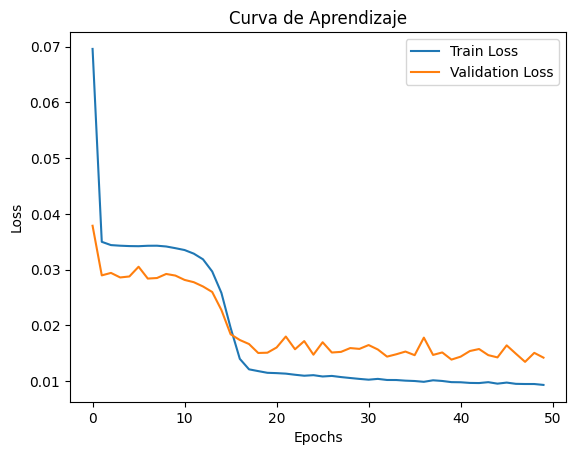

In [51]:
model, scaler_X, scaler_Y, X_test_reshaped, Y_test_reshaped = construir_modelo(X, Y, 20, 3, [50,30,20], act_lstm= 'sigmoid')

9/9 [==============================] - 1s 8ms/step


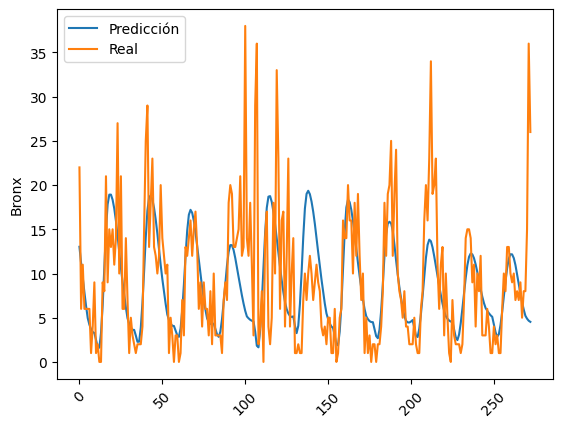

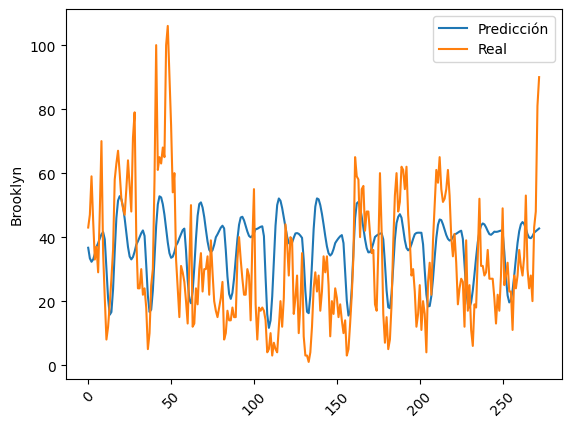

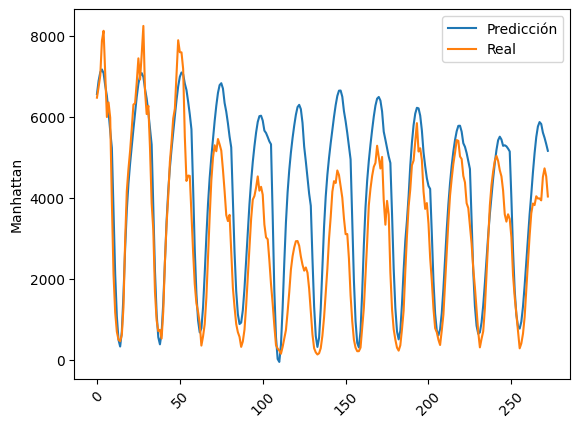

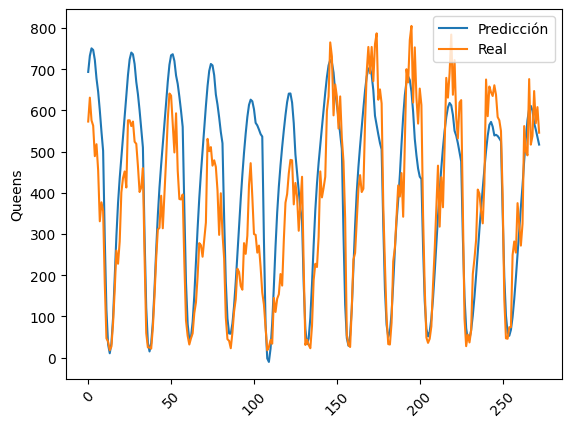

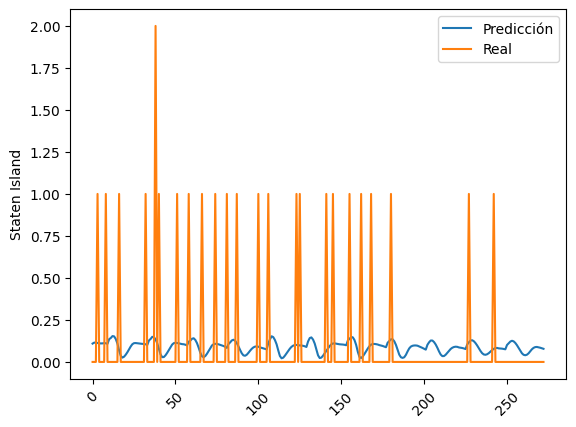

In [52]:
graficar_pred_test(X_test_reshaped, Y_test_reshaped, model, scaler_Y)